In [1]:
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import warnings
from sklearn import preprocessing
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore", category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Retriving the data from Google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
#Changing into pandas data frame
data = pd.read_csv('/content/gdrive/MyDrive/Dataset_Project/creditcard.csv')

# Data Analysis

In [4]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.shape

(6362620, 11)

In [7]:
#Missing values check
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

From above results we saw that none of the values are missed.

In [8]:
#Now checking the no of transactions per type.

type_count = data.type.value_counts()

print(type_count)

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Plotting number of transactions per type

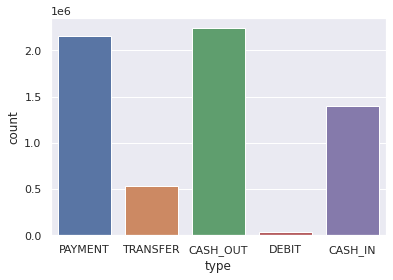

In [9]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="type", data=data)

Finding fradulent transactions in each type

In [10]:
type_count = data.isFraud.value_counts()

print(type_count)

0    6354407
1       8213
Name: isFraud, dtype: int64


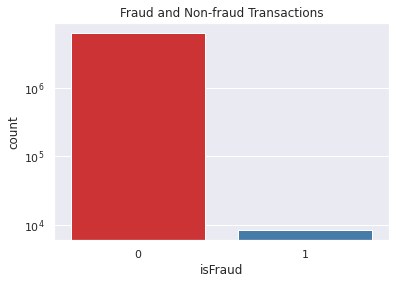

In [11]:
ax = sns.countplot(x="isFraud", data=data,palette = "Set1")
ax.set_yscale("log")
plt.title("Fraud and Non-fraud Transactions")
plt.show()

Finding out which type of transactions has fraudulent transactions

In [12]:
data.groupby("type")["isFraud"].sum()

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

Now we can remove other types of transactions except transfer and cash_in

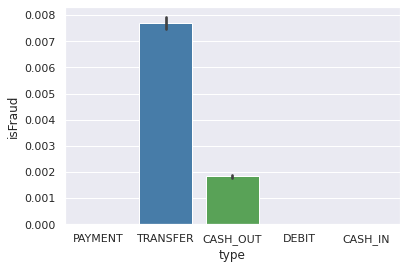

In [13]:
sns.barplot(y="isFraud",x ="type" ,data=data,palette = "Set1")

In [14]:

data_new = data[(data.type != 'PAYMENT') & ( data.type != 'DEBIT') & (data.type != 'CASH_IN')]


In [15]:
#Now checking the no of transactions per type.

type_count_new = data_new.type.value_counts()

print(type_count_new)

CASH_OUT    2237500
TRANSFER     532909
Name: type, dtype: int64


In [16]:
type_count_new = data_new.isFraud.value_counts()

print(type_count_new)

0    2762196
1       8213
Name: isFraud, dtype: int64


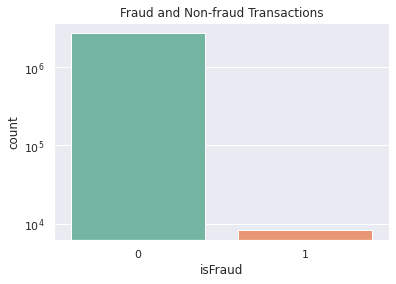

In [17]:
ax = sns.countplot(x="isFraud", data=data_new,palette = "Set2")
ax.set_yscale("log")
plt.title("Fraud and Non-fraud Transactions")
plt.show()

# Feature Engineering

##Finding highly co-related features

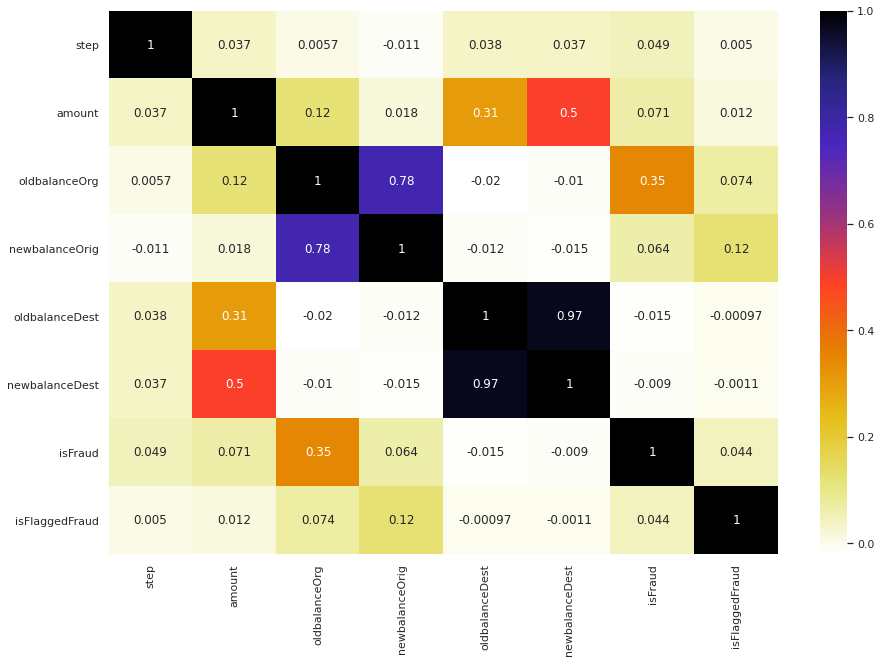

In [18]:
#implemneting corelation matrix
plt.figure(figsize=(15,10))
cor = data_new.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [19]:
#Finding the co-related features.

def correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
    return col_corr

In [20]:
corr_features = correlation(data_new, 0.7)

In [21]:
corr_features

['newbalanceOrig', 'newbalanceDest']

##One Hot endocing for TYPE feature

In [22]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder(sparse=False)

categorical_cols_type = ['type']

transformed_data = onehotencoder.fit_transform(data_new[categorical_cols_type])

# the above transformed_data is an array so convert it to dataframe
encoded_data = pd.DataFrame(transformed_data, index=data_new.index)

# now concatenate the original data and the encoded data using pandas
concatenated_data = pd.concat([data_new, encoded_data], axis=1)

concatenated_data = concatenated_data.drop(['type'],axis=1)


In [23]:
concatenated_data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,0,1
2,1,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0.0,1.0
3,1,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1.0,0.0
15,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1.0,0.0
19,1,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,0.0,1.0
24,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,0.0,1.0


##Removing co-related features

In [24]:
#Dropping target column and other features which are not useful

X = concatenated_data.drop(["isFraud","newbalanceOrig","newbalanceDest","nameOrig","nameDest"],axis=1)
#making y as predictor
y = concatenated_data["isFraud"]

##Preprocessing

In [25]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

In [26]:
print("Shape of a X  is ",X.shape)
print("Shape of a y  is ",y.shape)

Shape of a X  is  (2770409, 7)
Shape of a y  is  (2770409,)


# **Splitting the train,test and validation data**

In [27]:
#splitting test data and training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=12)

In [28]:
print("Shape of a X training is ",X_train.shape)
print("Shape of a y train is ",y_train.shape)
print("Shape of a X test is ",X_test.shape)
print("Shape of a y test is ",y_test.shape)

Shape of a X training is  (1939286, 7)
Shape of a y train is  (1939286,)
Shape of a X test is  (831123, 7)
Shape of a y test is  (831123,)


In [29]:
#splitting validation data and training data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=12)

In [30]:
print("Shape of a X training is ",X_train.shape)
print("Shape of a y train is ",y_train.shape)
print("Shape of a X test is ",X_test.shape)
print("Shape of a y test is ",y_test.shape)
print("Shape of a X validation is ",X_val.shape)
print("Shape of a y validation is ",y_val.shape)

print("values in train data" )
print(y_train.value_counts())

print("values in test data" )
print(y_test.value_counts())

print("values in validation data" )
print(y_val.value_counts())

Shape of a X training is  (1939286, 7)
Shape of a y train is  (1939286,)
Shape of a X test is  (415561, 7)
Shape of a y test is  (415561,)
Shape of a X validation is  (415562, 7)
Shape of a y validation is  (415562,)
values in train data
0    1933472
1       5814
Name: isFraud, dtype: int64
values in test data
0    414321
1      1240
Name: isFraud, dtype: int64
values in validation data
0    414403
1      1159
Name: isFraud, dtype: int64


# Metrics - ROC,Precision,Accuracy,F1,Recall

In [31]:
def plottingConfusionMatAndRoc(y_test, y_pred,y_prob):

    markers = ('s', 'x')
    colors = ('red', 'blue')

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")
    plt.figure(figsize=(5, 5))
    plt.show()
    #fig.tight_layout()

    # -----------------------------------------------------
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw = 2, label = 'AUC: {:.2f}'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1],
             linestyle = '--',
             color = (0.6, 0.6, 0.6),
             label = 'Random guessing')
    plt.plot([0, 0, 1], [0, 1, 1],
             linestyle = ':',
             color = 'black', 
             label = 'Perfect performance')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operator Characteristic (ROC) Curve')
    plt.legend(loc = "lower right")
    plt.figure(figsize=(5, 5))
    plt.show()
    #----------------------------------------

    print(classification_report(y_test, y_pred))
   

# Defining Naive Bayes

In [32]:
def naiveBayes(X_train, y_train,X_test,y_test):
  #Performing Naive Bayes
   naive_bayes_model = GaussianNB()

   #Hyper tuning the model
   cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)

   #grid search
   params_NB = {'var_smoothing': np.logspace(0,-9, num=30)}
   gv = GridSearchCV(naive_bayes_model,params_NB,verbose=2, cv = cv,scoring= 'accuracy')

   #fitting the model
   gv.fit(X_train, y_train);

   y_pred = gv.predict(X_test)
   y_prob = gv.predict_proba(X_test)[:, 1]

   #Confusion matrix and ROC curve for naive bayes
   plottingConfusionMatAndRoc(y_test,y_pred,y_prob)

## Logistic Regression

In [33]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def logisticRegression(X_train, y_train,X_test,y_test):
 # Setup the hyperparameter grid
 c_space = np.logspace(0.01,100,10)
 param_grid = {'C': c_space}

 # Instantiate a logistic regression classifier: logreg
 logreg = LogisticRegression()

 # Instantiate the GridSearchCV object: logreg_cv
 logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

 # Fit it to the data
 logreg_cv.fit(X_train, y_train)

 y_pred = logreg_cv.predict(X_test)
 y_prob = logreg_cv.predict_proba(X_test)[:, 1]

 #Confusion matrix and ROC curve for naive bayes
 plottingConfusionMatAndRoc(y_test,y_pred,y_prob)

##**Predicting on validation dataset without any sampling technique**

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.6s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   47.3s finished


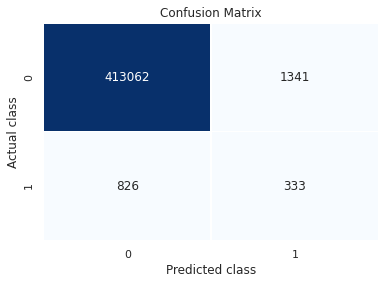

<Figure size 360x360 with 0 Axes>

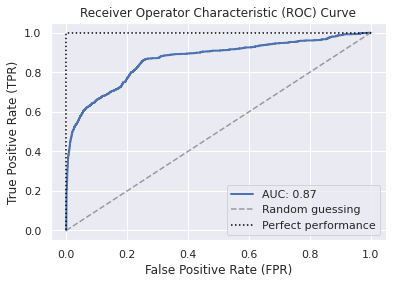

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    414403
           1       0.20      0.29      0.24      1159

    accuracy                           0.99    415562
   macro avg       0.60      0.64      0.62    415562
weighted avg       1.00      0.99      1.00    415562



In [34]:
#validation data set
naiveBayes(X_train, y_train,X_val,y_val)

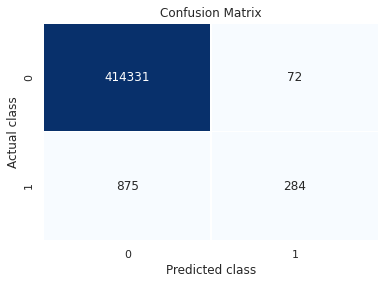

<Figure size 360x360 with 0 Axes>

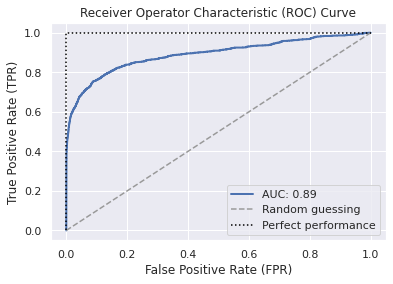

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    414403
           1       0.80      0.25      0.37      1159

    accuracy                           1.00    415562
   macro avg       0.90      0.62      0.69    415562
weighted avg       1.00      1.00      1.00    415562



In [35]:
logisticRegression(X_train, y_train,X_val,y_val)

##**Predictiong on test dataset without any sampling technique**

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   48.2s finished


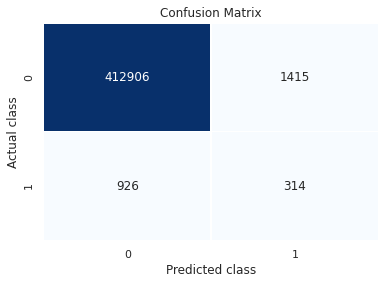

<Figure size 360x360 with 0 Axes>

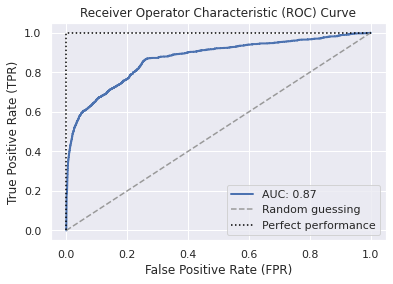

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    414321
           1       0.18      0.25      0.21      1240

    accuracy                           0.99    415561
   macro avg       0.59      0.62      0.60    415561
weighted avg       1.00      0.99      0.99    415561



In [36]:
naiveBayes(X_train, y_train,X_test,y_test)

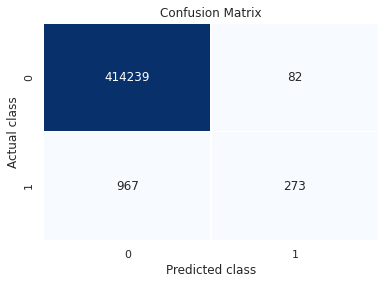

<Figure size 360x360 with 0 Axes>

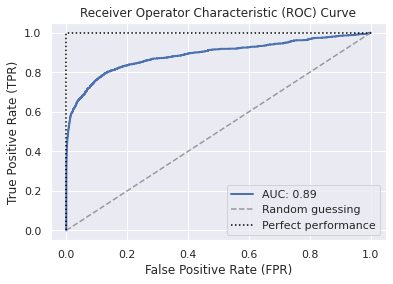

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    414321
           1       0.77      0.22      0.34      1240

    accuracy                           1.00    415561
   macro avg       0.88      0.61      0.67    415561
weighted avg       1.00      1.00      1.00    415561



In [37]:
logisticRegression(X_train, y_train,X_test,y_test)

# OverSampling using SMOTE

In [38]:
#Over sampling
over_sampling = SMOTE(ratio='minority',random_state =12)
#over_sampling = SMOTE(ratio=1,random_state =42)
#over_sampling = SMOTE(ratio={1: 966718, 0: 966718},random_state =42)
X_sm, y_sm = over_sampling.fit_sample(X_train, y_train)

print("Before Oversampling")
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

print("After Oversampling")
print(X_sm.shape)
print(y_sm.shape)

(unique, counts) = np.unique(y_sm, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

Before Oversampling
(1939286, 7)
(1939286,)
0    1933472
1       5814
Name: isFraud, dtype: int64
After Oversampling
(3866944, 7)
(3866944,)
[[      0 1933472]
 [      1 1933472]]


## **Predicting on  validation dataset**

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   1.1s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ................................ var_smoothing=1.0, total=   1.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   1.0s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   1.0s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   1.0s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   1.0s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   1.0s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   1.0s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.5min finished


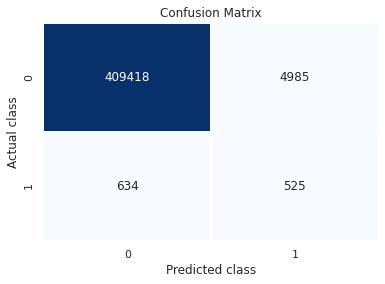

<Figure size 360x360 with 0 Axes>

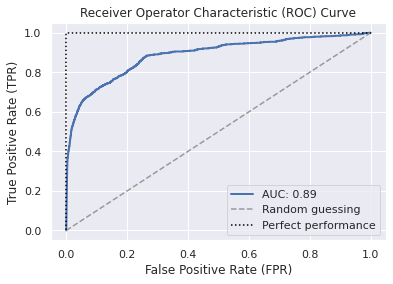

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    414403
           1       0.10      0.45      0.16      1159

    accuracy                           0.99    415562
   macro avg       0.55      0.72      0.58    415562
weighted avg       1.00      0.99      0.99    415562



In [39]:
#validation data set after up sampling
naiveBayes(X_sm, y_sm,X_val,y_val)

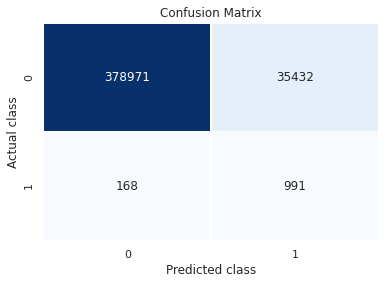

<Figure size 360x360 with 0 Axes>

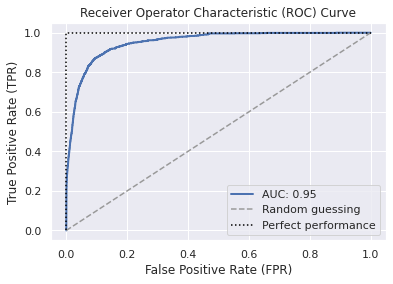

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.91      0.96    414403
           1       0.03      0.86      0.05      1159

    accuracy                           0.91    415562
   macro avg       0.51      0.88      0.50    415562
weighted avg       1.00      0.91      0.95    415562



In [40]:
logisticRegression(X_sm, y_sm,X_val,y_val)

##**predicting on test data**

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   1.0s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ................................ var_smoothing=1.0, total=   1.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   1.0s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   1.0s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   1.0s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   1.0s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   1.0s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   1.0s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.5min finished


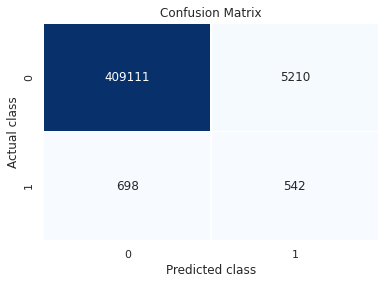

<Figure size 360x360 with 0 Axes>

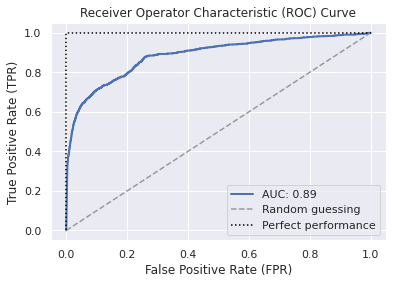

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    414321
           1       0.09      0.44      0.16      1240

    accuracy                           0.99    415561
   macro avg       0.55      0.71      0.57    415561
weighted avg       1.00      0.99      0.99    415561



In [41]:
#performing naive bayes after oversampling
naiveBayes(X_sm, y_sm,X_test,y_test)

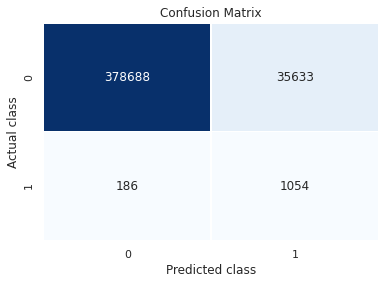

<Figure size 360x360 with 0 Axes>

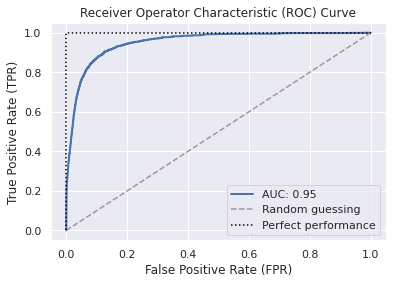

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    414321
           1       0.03      0.85      0.06      1240

    accuracy                           0.91    415561
   macro avg       0.51      0.88      0.51    415561
weighted avg       1.00      0.91      0.95    415561



In [42]:
logisticRegression(X_sm, y_sm,X_test,y_test)

# Random UnderSampling

In [43]:
#Under sampling

from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(ratio='majority',random_state =12)

#X_under, y_under = rus.fit_sample(X_train, y_train)

u_sample = RandomUnderSampler(ratio='majority',random_state=12)
X_train_u, y_train_u = u_sample.fit_resample(X_train, y_train)
y_train_u=np.array([y_train_u])
y_train_u=y_train_u.T

for i in range(1,167):
  u_sample = RandomUnderSampler(ratio='majority',random_state=i)
  X, y = u_sample.fit_resample(X_train, y_train)
  y=np.array([y])
  y=y.T
  X_train_u = np.vstack((X_train_u, X))
  y_train_u = np.vstack((y_train_u, y))
y_train_u=y_train_u.reshape(1941876,)

print("Before undersampling")
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

print("After undersampling")
print(X_train_u.shape)
print(y_train_u.shape)

(unique, counts) = np.unique(y_train_u, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)


Before undersampling
(1939286, 7)
(1939286,)
0    1933472
1       5814
Name: isFraud, dtype: int64
After undersampling
(1941876, 7)
(1941876,)
[[     0 970938]
 [     1 970938]]


##**Prediction on Validation dataset**

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   46.9s finished


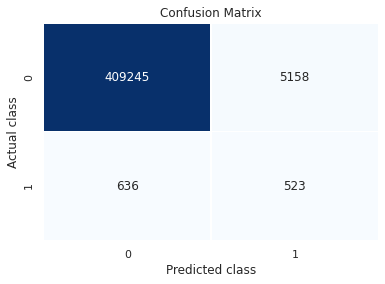

<Figure size 360x360 with 0 Axes>

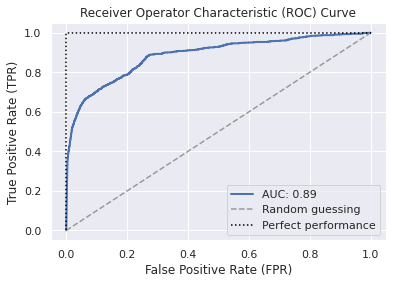

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    414403
           1       0.09      0.45      0.15      1159

    accuracy                           0.99    415562
   macro avg       0.55      0.72      0.57    415562
weighted avg       1.00      0.99      0.99    415562



In [44]:
#Validation set
naiveBayes(X_train_u, y_train_u,X_val,y_val)

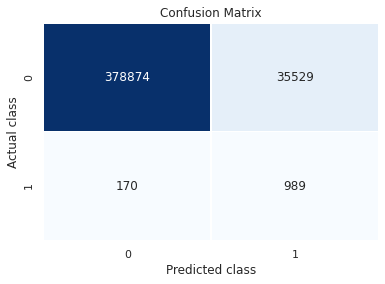

<Figure size 360x360 with 0 Axes>

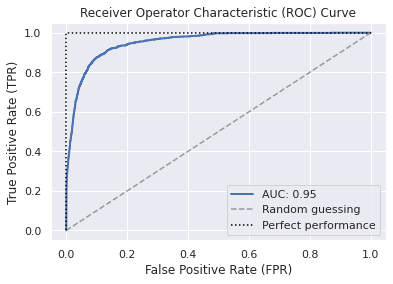

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.91      0.96    414403
           1       0.03      0.85      0.05      1159

    accuracy                           0.91    415562
   macro avg       0.51      0.88      0.50    415562
weighted avg       1.00      0.91      0.95    415562



In [45]:
logisticRegression(X_train_u, y_train_u,X_val,y_val)

##**Predicting on Test data**

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.48939009184774934 ...............................
[CV] ................ var_smoothing=0.48939009184774934, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] ................ var_smoothing=0.23950266199874853, total=   0.5s
[CV] var_smoothing=0.23950266199874853 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   48.2s finished


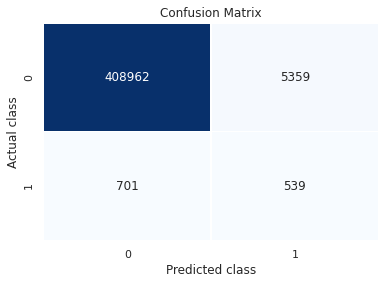

<Figure size 360x360 with 0 Axes>

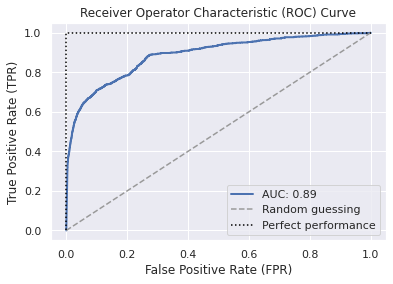

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    414321
           1       0.09      0.43      0.15      1240

    accuracy                           0.99    415561
   macro avg       0.54      0.71      0.57    415561
weighted avg       1.00      0.99      0.99    415561



In [46]:
#Test set
naiveBayes(X_train_u, y_train_u,X_test,y_test)

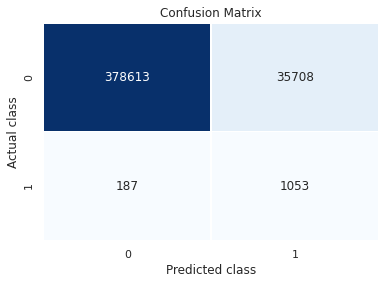

<Figure size 360x360 with 0 Axes>

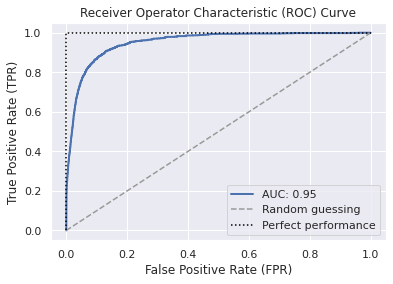

<Figure size 360x360 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    414321
           1       0.03      0.85      0.06      1240

    accuracy                           0.91    415561
   macro avg       0.51      0.88      0.51    415561
weighted avg       1.00      0.91      0.95    415561



In [47]:
logisticRegression(X_train_u, y_train_u,X_test,y_test)